# Problem1

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as ftl
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt
import samplers
import torch.optim as optim


### Disctrimiator class

In [0]:
#disctrimiator
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),

        )

    def forward(self, x):
        return self.model(x)

### Estimate the JSD between two distributions

In [0]:
def estimate_JSD(dist1, dist2, num_epochs,dim_input=2):

    D = Classifier(dim_input).cuda()
  
    #optimizer = SGD(D.parameters(), lr=0.001)
    optimizer = optim.Adam(D.parameters())
    for it in range(num_epochs):
        D.zero_grad()
        x_1 = torch.from_numpy(next(dist1)).float().cuda()
        x_2 = torch.from_numpy(next(dist2)).float().cuda()
        y_1 = ftl.sigmoid(D(x_1))
        y_2 = ftl.sigmoid(D(x_2))
        loss = - torch.log(y_1).mean() - torch.log(1 - y_2).mean()
        loss.backward()
        optimizer.step()
        g=np.log(2) + (0.5*torch.log(y_1).mean() + 0.5*torch.log(1 - y_2).mean()).data.cpu().numpy()
    return D,g


### Estimate the WD between two distributions

In [0]:
def estimate_WD(dist1, dist2,num_epochs ):
  
    D = Classifier(2).cuda()
    #optimizer = SGD(D.parameters(), lr=0.001)
    optimizer = optim.Adam(D.parameters())

    dist_a = samplers.distribution2()
    lambda_ = 10

    for it in range(num_epochs):
        D.zero_grad()
        x_1 = torch.from_numpy(next(dist1)).float().cuda()
        x_2 = torch.from_numpy(next(dist2)).float().cuda()
        y_1 = D(x_1)
        y_2 = D(x_2)
        a = torch.from_numpy(next(dist_a)).float().cuda()
        z = a*x_1 + (1 - a)*x_2
        z.requires_grad = True
        y_z = D(z)
        grad_z = torch.autograd.grad(y_z, z, grad_outputs=torch.ones(y_z.size()).cuda(), retain_graph=True, create_graph=True, only_inputs=True)[0]
        loss = -(torch.mean(y_1) - torch.mean(y_2) - lambda_*torch.mean((torch.norm(grad_z, p=2, dim=1)-1)**2))
            
        loss.backward()
        optimizer.step()
    return (torch.mean(y_1) - torch.mean(y_2)).data.cpu().numpy()


### Plotting the estimated JSD and the WD



x = -1.0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


x = -0.9
x = -0.8
x = -0.7
x = -0.6
x = -0.5
x = -0.4
x = -0.3
x = -0.2
x = -0.1
x = -0.0
x = 0.1
x = 0.2
x = 0.3
x = 0.4
x = 0.5
x = 0.6
x = 0.7
x = 0.8
x = 0.9
x = 1.0


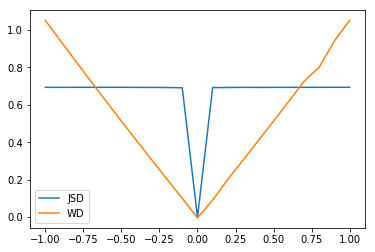

In [12]:
JSD_point=[]
WD_point=[]
dist1 = samplers.distribution1(0)
data_points= np.linspace(-1, 1, 21)
for x in np.arange(-1.0, 1.01, 0.1):
  x = np.around(x, decimals=1)
  print("x = " + str(x))
  dist2 = samplers.distribution1(x)
  _,y=estimate_JSD(dist1, dist2,1000)
  JSD_point.append(y)
  WD_point.append(estimate_WD(dist1, dist2,1000))
plt.plot(data_points, JSD_point, label="JSD")
plt.plot(data_points, WD_point, label="WD")
plt.legend()
plt.show()


### Plotting  the discriminator output and the estimated density

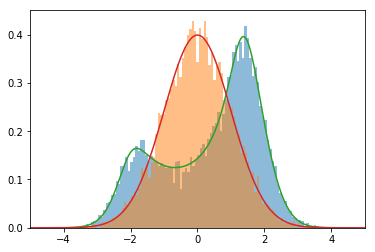

In [15]:
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
 # exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))

In [17]:
f_0 = samplers.distribution3(512)
f_1 = samplers.distribution4(512)

D, _ = estimate_JSD(f_1, f_0,1000,dim_input=1)     

discriminator_input =torch.unsqueeze(torch.from_numpy(xx).float().cuda(), 1)
discriminator_output = torch.squeeze(ftl.sigmoid(D(discriminator_input)), 1).data.cpu().numpy()
f_estimate = N(xx)*discriminator_output/(1-discriminator_output)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'Estimated vs True')

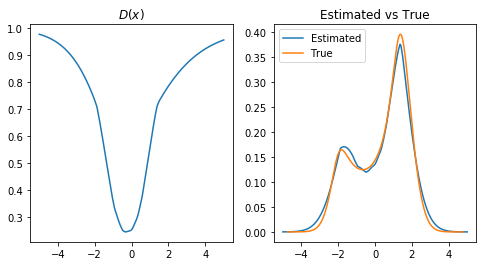

In [19]:
r = discriminator_output # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')

estimate = f_estimate # estimate the density of distribution4 (on xx) using the discriminator; 
                                # replace "np.ones_like(xx)*0." with your estimate
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')
